In [1]:
pip install sentence-transformers --quiet

In [2]:
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from urllib.parse import urlparse

import re

import random

from sentence_transformers import SentenceTransformer, util


In [3]:
RANDOM_SEED = 5123

### Цель проекта

Цель этого проекта - разработка решения, которое отчасти автоматизирует процесс
сопоставления товаров. Основная идея - предлагать несколько товаров заказчика,
которые с наибольшей вероятностью соответствуют размечаемому товару дилера.
Предлагается реализовать это решение, как онлайн сервис, открываемый в веб-
браузере. Выбор наиболее вероятных подсказок делается методами машинного
обучения.

### Предоставление вариантов соответствия:

Система должна использовать рекомендательную модель, созданную ML
специалистами, для предоставления наиболее вероятных вариантов соответствия
товара.
Для каждого товара система должна предложить несколько (настраиваемое
количество) вариантов соответствия.

### Описание данных

Описание данных
Заказчик предоставил несколько таблиц (дамп БД), содержащих необходимые
данные:
1. `marketing_dealer` - список дилеров;
2. `marketing_dealerprice` - результат работы парсера площадок дилеров:
   - product_key - уникальный номер позиции;
   - price - цена;
   - product_url - адрес страницы, откуда собраны данные;
   - product_name - заголовок продаваемого товара;
   - date - дата получения информации;
   - dealer_id - идентификатор дилера (внешний ключ к marketing_dealer)
  
3. `marketing_product` - список товаров, которые производит и распространяет
заказчик;
   - article - артикул товара;
   - ean_13 - код товара (см. EAN 13). Прим: *`ean_13 - European Article Number`
   - name - название товара;
   - cost - стоимость;
   - min_recommended_price - рекомендованная минимальная цена;
   - recommended_price - рекомендованная цена;
   - category_id - категория товара;
   - ozon_name - названиет товара на Озоне;
   - name_1c - название товара в 1C;
   - wb_name - название товара на Wildberries;
   - ozon_article - описание для Озон;
   - wb_article - артикул для Wildberries;
   - ym_article - артикул для Яндекс.Маркета;

4. `marketing_productdealerkey` - таблица матчинга товаров заказчика и товаров
дилеров
   - key - внешний ключ к marketing_dealerprice
   - product_id - внешний ключ к marketing_product
   - dealer_id - внешний ключ к marketing_dealer

In [4]:
# Connecting Google Drive to Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
folder_path = "/content/drive/My Drive/hackathon/"

In [6]:
class analyzer():

    def __init__(self, folder_path):
        self.marketing_dealer = pd.read_csv(folder_path + "marketing_dealer.csv", sep=';', index_col='id')
        self.marketing_dealer_price = pd.read_csv(folder_path + "marketing_dealerprice.csv", sep=';', parse_dates=['date'])
        self.marketing_product = pd.read_csv(folder_path + "marketing_product.csv", sep=';', index_col='id')
        self.marketing_product_dealer_key = pd.read_csv(folder_path + "marketing_productdealerkey.csv", sep=';', index_col='id')

        self.marketing_dealer.sort_index(inplace=True)
        self.marketing_dealer_price.sort_index(inplace=True)
        self.marketing_product.sort_index(inplace=True)
        self.marketing_product_dealer_key.sort_index(inplace=True)

    #region misses
    def check_misses_marketing_dealer(self):
        analyzer.__plot_misses(spaced_data = analyzer.__count_misses(self.marketing_dealer),
                               dataset_name ='marketing_dealer')


    def check_misses_marketing_dealer_price(self):
        analyzer.__plot_misses(spaced_data = analyzer.__count_misses(self.marketing_dealer_price),
                               dataset_name = 'marketing_dealer_price')


    def check_misses_marketing_product(self):
        analyzer.__plot_misses(spaced_data = analyzer.__count_misses(self.marketing_product),
                               dataset_name = 'marketing_product')

    def check_misses_marketing_product_dealer_key(self):
        analyzer.__plot_misses(spaced_data = analyzer.__count_misses(self.marketing_product_dealer_key),
                               dataset_name = 'marketing_product_dealer_key')
    #endregion


    #region duplicates
    def check_duplicates_marketing_dealer(self):
        analyzer.__check_duplicates(data = self.marketing_dealer,
                                    dataset_name ='marketing_dealer')

    def check_duplicates_marketing_dealer_price(self):
        analyzer.__check_duplicates(data = self.marketing_dealer_price,
                                    dataset_name ='marketing_dealer_price')

    def check_duplicates_marketing_product(self):
        analyzer.__check_duplicates(data = self.marketing_product,
                                    dataset_name ='marketing_product')

    def check_duplicates_marketing_product_dealer_key(self):
        analyzer.__check_duplicates(data = self.marketing_product_dealer_key,
                                    dataset_name ='marketing_product_dealer_key')
    #endregion


    def merger(self):

        self.merged_df = self.marketing_dealer_price.merge(self.marketing_dealer,
                                                           left_on='dealer_id',
                                                            right_index=True)
        self.merged_df  = self.marketing_dealer_price.merge(self.marketing_dealer, left_on='dealer_id', right_index=True)
        self.merged_df  = self.merged_df.merge(self.marketing_product_dealer_key,
                            left_on='product_key',
                            right_on='key')
        self.merged_df = self.merged_df.merge(self.marketing_product,
                            left_on='product_id',
                            right_on='id')
        self.merged_df.drop(columns=['product_key','dealer_id_x','name_x',
                                     'key','dealer_id_y',], inplace=True)
        self.merged_df.rename(columns={'name_y':'original_name'}, inplace=True)





    #region helper
    @staticmethod
    def __count_misses(data):
        spaced_data = (
            (data.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending=True)
        )
        return spaced_data


    @staticmethod
    def __plot_misses(spaced_data, dataset_name):
        if spaced_data.empty:
            print(f'Пропуски в датасете "{dataset_name}" не обнаружены')
        else:
            ax = (
                spaced_data
                .plot
                .barh(y='space', figsize = (12,8), rot = 0, legend = False, fontsize = 16, color='firebrick'))
            ax.xaxis.set_ticks([10,20,30,40,50,60,70,80,90])
            ax.set_title(f'Количество пропусков в {dataset_name}' + '\n', fontsize = 20, color='black')
            ax.set_xlabel('Пропуски по колонкам')
            for i, v in enumerate(spaced_data.space):
                ax.text(v + 0.5, i - .1, '{:,.2f}%'.format((v)), color='black', fontweight='bold')

    @staticmethod
    def __check_duplicates(data, dataset_name):
        duplicates = data[data.duplicated()]
        if duplicates.empty:
            print(f'Дубликаты в "{dataset_name}" не обнаружены')
        else:
            print(f'Количество дубликатов в "{dataset_name}": {duplicates.shape[0]}')
    #endregion

    @classmethod
    def plot_hist(cls, data_col):
        fig = plt.figure(figsize=(12,12))

        ax_1 = fig.add_subplot(2, 1, 1)
        ax_2 = fig.add_subplot(2, 2, 3)
        ax_3 = fig.add_subplot(2, 2, 4)

        fig.suptitle(f'Колонка: {data_col.name} \n', fontsize=18)

        sns.histplot(data_col, kde=False, ax=ax_1)
        ax_1.set_title('Histogram - "Price"')

        sns.histplot(data_col, kde=False, ax=ax_2)
        ax_2.set_title('Histogram - Right Tail')
        ax_2.set_xlim(0, np.percentile(data_col[data_col.notna()], 95))

        sns.boxplot(x=data_col, ax=ax_3)
        ax_3.set_title('Box-and-Whiskers Plot')

        plt.tight_layout()
        plt.show()

In [7]:
prosept = analyzer(folder_path)

### Marketing_dealer

In [8]:
prosept.marketing_dealer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 1 to 18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    18 non-null     object
dtypes: object(1)
memory usage: 288.0+ bytes


In [9]:
prosept.marketing_dealer.sample(5, random_state=RANDOM_SEED)

,name
id,
5,Castorama
15,Vse_instrumeni
3,Bafus
16,Vimos
10,OnlineTrade


Датасет `marketing_dealer` представляет собой наименование диллерсих сетей. Всего в датасете находится 18 уникальных значений, котороым соответсвует уникальный ключ - `id`

In [10]:
prosept.check_misses_marketing_dealer()

Пропуски в датасете "marketing_dealer" не обнаружены


Пропусков в данных нет. Посмотрим на дубликаты:

In [11]:
prosept.check_duplicates_marketing_dealer()

Дубликаты в "marketing_dealer" не обнаружены


## Marketing_dealer_price

In [12]:
prosept.marketing_dealer_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20416 entries, 0 to 20415
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            20416 non-null  int64         
 1   product_key   20416 non-null  object        
 2   price         20416 non-null  float64       
 3   product_url   20182 non-null  object        
 4   product_name  20416 non-null  object        
 5   date          20416 non-null  datetime64[ns]
 6   dealer_id     20416 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 1.1+ MB


In [13]:
prosept.marketing_dealer_price.sample(5, random_state=RANDOM_SEED)

,id,product_key,price,product_url,product_name,date,dealer_id
19187,19338,https://kub02.ru/catalog/prosept/antiseptik_ne...,858.0,https://kub02.ru/catalog/prosept/antiseptik_ne...,Антисептик невымываемый (коричневый) PROSEPT U...,2023-07-31,6
8621,8682,200375969,5401.0,https://www.bafus.ru/200375969/,Просепт Огнебио Prof 1 огнебиозащита для древе...,2023-07-18,3
1288,1281,15881559,585.0,https://www.vseinstrumenti.ru/product/zhidkoe-...,Жидкое гель-мыло с перламутром без красителей ...,2023-07-11,15
9217,9246,2717033,550.0,https://www.onlinetrade.ru/catalogue/propitki_...,"Антисептик невымываемый PROSEPT ULTRA, 1 литр,...",2023-07-18,10
17609,17761,1001472283,414.0,https://www.castorama.ru/sr_vo_dlya_stir_chyer...,Жидкое средство для стирки черных тканей Prose...,2023-07-28,5


### Неверные значения в product_key

In [14]:
prosept.marketing_dealer_price['product_key'][~prosept.marketing_dealer_price['product_key'].str.isdigit()].head(5)

703    https://kub02.ru/catalog/professionalnaya_byto...
704    https://kub02.ru/catalog/prosept/antiseptik_un...
705    https://kub02.ru/catalog/professionalnaya_byto...
706    https://kub02.ru/catalog/kraska_i_gruntovka/kr...
707    https://kub02.ru/catalog/professionalnaya_byto...
Name: product_key, dtype: object

В строке `product_key` есть ссылки. Данная строка нужна нам для получения ключей продукта, следовательно данные значения можно удалять. Отчистим лишние пробелы, затем посмотрим ещё раз:

In [15]:
prosept.marketing_dealer_price['product_key'] = prosept.marketing_dealer_price['product_key'].str.strip()
prosept.marketing_dealer_price['product_key'][~prosept.marketing_dealer_price['product_key'].str.isdigit()].shape[0]

240

Всего найдено 240 объектов, где `product_key` является ссылкой. Удаляем некорректные значения:

In [16]:
prosept.marketing_dealer_price = prosept.marketing_dealer_price[prosept.marketing_dealer_price['product_key'].str.isdigit()]
prosept.marketing_dealer_price.reset_index(drop=True, inplace=True)
prosept.marketing_dealer_price['product_key'][~prosept.marketing_dealer_price['product_key'].str.isdigit()].shape[0]

0

In [17]:
prosept.marketing_dealer_price

,id,product_key,price,product_url,product_name,date,dealer_id
0,2,546227,233.0,https://akson.ru//p/sredstvo_universalnoe_pros...,Средство универсальное Prosept Universal Spray...,2023-07-11,2
1,3,546408,175.0,https://akson.ru//p/kontsentrat_prosept_multip...,"Концентрат Prosept Multipower для мытья полов,...",2023-07-11,2
2,4,546234,285.0,https://akson.ru//p/sredstvo_dlya_chistki_lyus...,Средство для чистки люстр Prosept Universal An...,2023-07-11,2
3,5,651258,362.0,https://akson.ru//p/udalitel_rzhavchiny_prosep...,"Удалитель ржавчины PROSEPT RUST REMOVER 0,5л 0...",2023-07-11,2
4,6,546355,205.0,https://akson.ru//p/sredstvo_moyushchee_dlya_b...,Средство моющее для бани и сауны Prosept Multi...,2023-07-11,2
...,...,...,...,...,...,...,...
20171,20566,534517451,823.0,https://www.ozon.ru/product/534517451,"Огнебиозащита для древесины PROSEPT 2 группа, ...",2023-07-31,18
20172,20567,530308963,418.0,https://www.ozon.ru/product/530308963,"Антисептик многофункциональный ФБС, ГОСТ 5 л",2023-07-31,18
20173,20568,531730388,2986.0,https://www.ozon.ru/product/531730388,"Средство для удаления ржавчины PROSEPT, 1 шт",2023-07-31,18
20174,20569,1090913025,579.0,https://www.ozon.ru/product/1090913025,Герметик акриловый межшовный для деревянных ко...,2023-07-31,18


In [18]:
prosept.marketing_dealer_price['product_name'].describe()

count                                                 20176
unique                                                 1930
top       Просепт Bio Lasur антисептик лессирующий защит...
freq                                                    117
Name: product_name, dtype: object

В тексте имеется `20176` значений и всего `1930` уникальных для колонки `product_name`. Отчистим дубликаты позже. Посмотрим на количество пропусков:

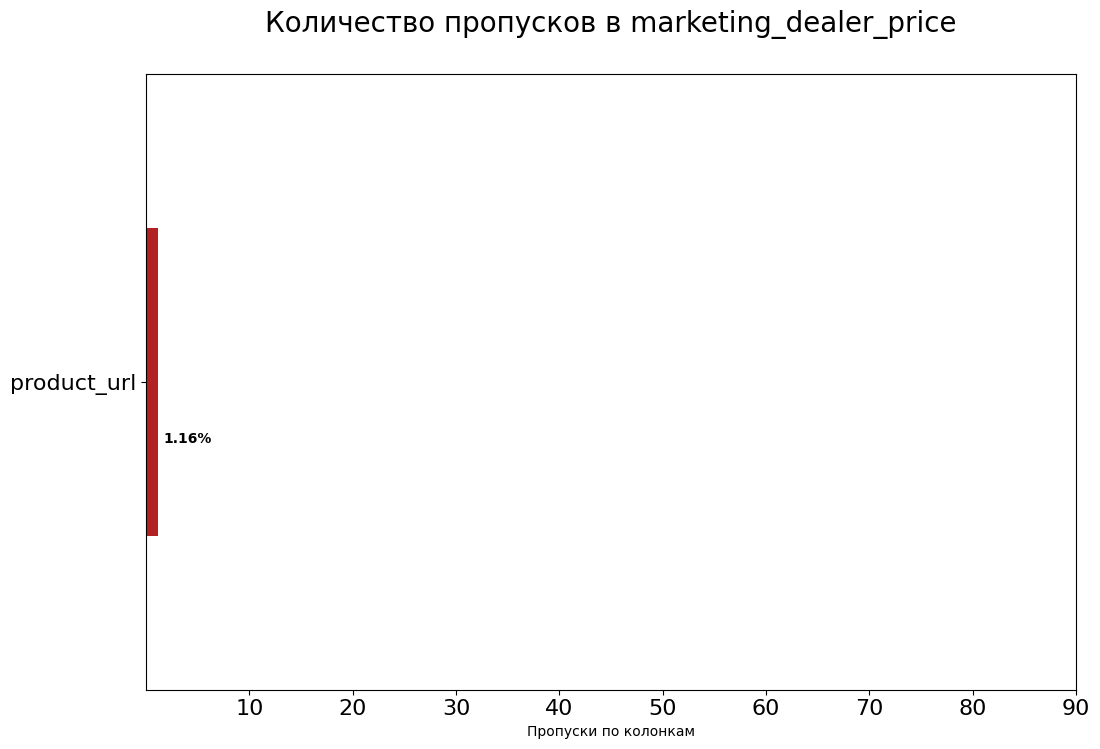

In [19]:
prosept.check_misses_marketing_dealer_price()

В датафрейме всего `1.16%` в колонке `product_url`. Их можно пропустить. Вернемся к дубликатам:

In [20]:
prosept.check_duplicates_marketing_dealer_price()

Дубликаты в "marketing_dealer_price" не обнаружены


В датасете найдено полных 726 дубликатов. Скорее всего их больше. Посмотрим на них без колонки `date`:

In [21]:
prosept.marketing_dealer_price[prosept.marketing_dealer_price
                               .drop(columns=['date'])
                               .duplicated(keep=False)].sort_values(by='product_key').head(10)

,id,product_key,price,product_url,product_name,date,dealer_id


In [22]:
duplicates = prosept.marketing_dealer_price[prosept.marketing_dealer_price
                               .drop(columns=['date'])
                               .duplicated(keep=False)].sort_values(by='product_key').shape[0]

Количество дубликатов составляет:
1. `726` полных дубликатов - парсинг был осуществлен в один и тот же день;
2. `19092` неполных дубликатов (без колонки `date`) - одни и те же товары, парсинг которых состоялся в разный день.

Оставим только уникальные запросы:

In [23]:
prosept.marketing_dealer_price['product_name'].unique()

array(['Средство универсальное Prosept Universal Spray, 500мл',
       'Концентрат Prosept Multipower для мытья полов, цитрус 1л',
       'Средство для чистки люстр Prosept Universal Anti-dust, 500мл',
       ...,
       'Средство для удаления клейкой ленты, клея, наклеек 0,4л PROSEPT Duty Universal готовый состав',
       'Отбеливатель для древесины PROSEPT ECO 50 готовый состав 1 кг',
       'Герметик акриловый межшовный для деревянных конструкций, цвет "Орех" готовый состав 0,6 кг'],
      dtype=object)

In [24]:
prosept.marketing_dealer_price.drop_duplicates(subset=['product_name'] ,
                                               keep='last',
                                               inplace=True)

In [25]:
prosept.marketing_dealer_price.shape[0]

1930

Проверим, остались ли дубликаты:

In [26]:
prosept.marketing_dealer_price[prosept.marketing_dealer_price
                               .drop(columns=['date'])
                               .duplicated(keep=False)].sort_values(by='product_key').shape[0]

0

Посмотрим на диапазон дат:

In [27]:
prosept.marketing_dealer_price.date.value_counts()

2023-07-31    1710
2023-07-12      65
2023-07-18      41
2023-07-21      37
2023-07-28      32
2023-07-17      18
2023-07-26       9
2023-07-19       6
2023-07-14       5
2023-07-25       3
2023-07-11       2
2023-07-24       2
Name: date, dtype: int64

In [28]:
round(prosept.marketing_dealer_price.date.value_counts()[0] /
      (prosept.marketing_dealer_price.date.value_counts()[0] +
       prosept.marketing_dealer_price.date.value_counts()[1:].sum()), 2)

0.89

Больше половины данных были, а имеено `89%` были добыты в одинь день - `2023-07-31`.

Посмотрим на цены

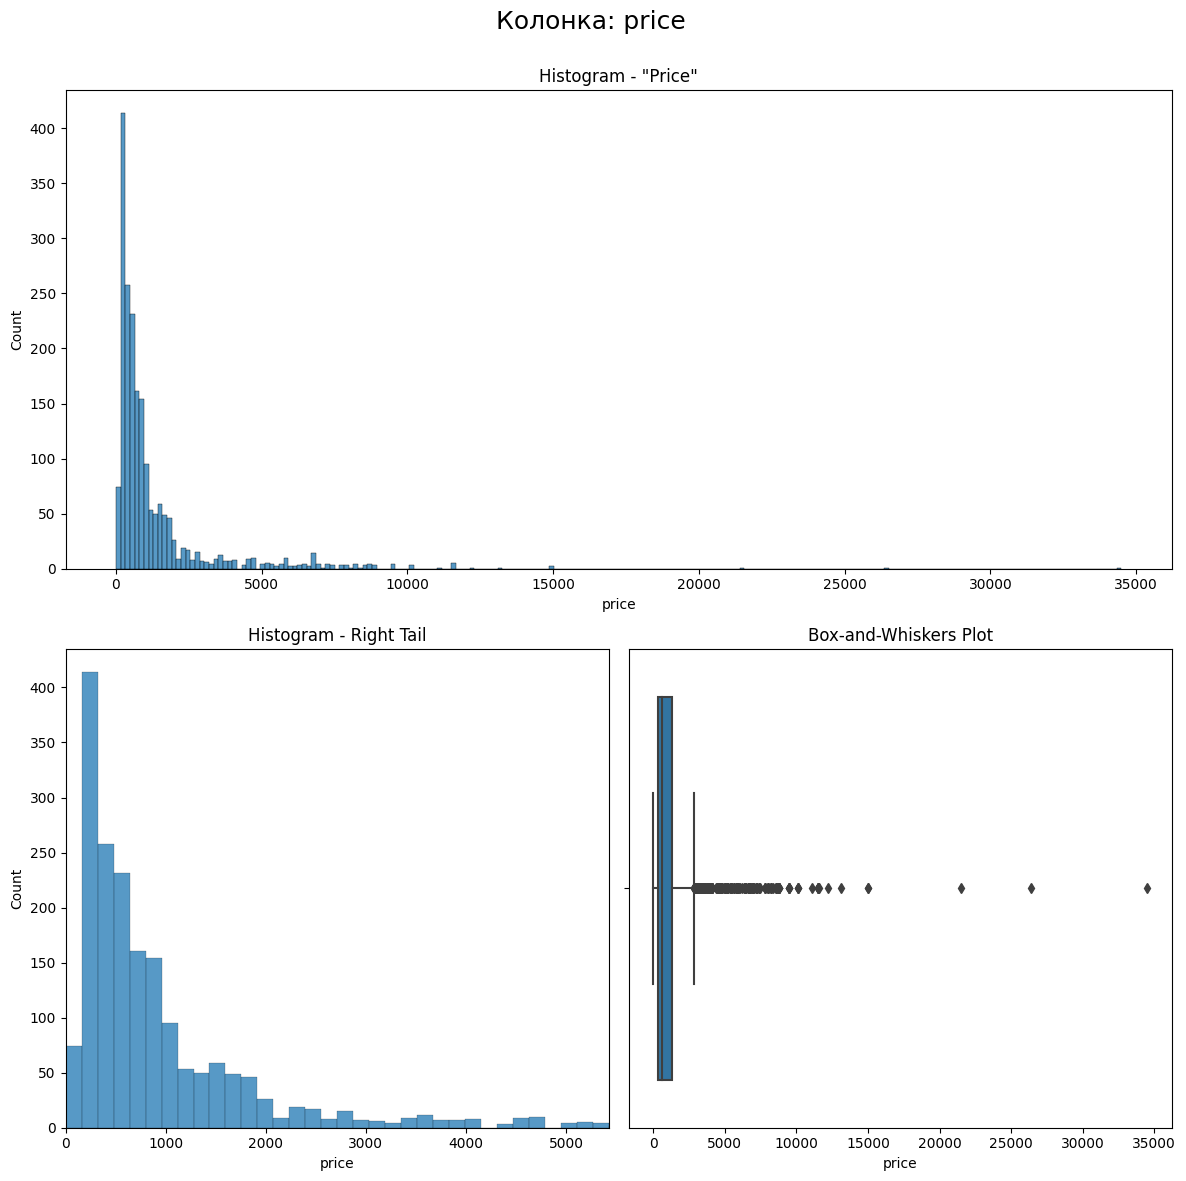

In [29]:
analyzer.plot_hist(prosept.marketing_dealer_price['price'])

In [30]:
prosept.marketing_dealer_price['price'].describe()

count     1930.000000
mean      1285.336788
std       2079.956125
min          0.000000
25%        319.000000
50%        626.000000
75%       1314.750000
max      34500.000000
Name: price, dtype: float64

In [31]:
round(prosept.marketing_dealer_price['price'].quantile(.995),2)

11528.36

Можно сделать следующие выводы:
1. `95% данных` лежит в деапазоне до ~5 тысяч.
2. `Среднее` больше `медианы` в 2 раза, что говорит нам о длинном правом хвосте.
3. Цена до `10050.1` содержит в себе 99,5% всего товара.

Следовательно, либо есть редкие, но очень дорогие позиции, либо это аномалии. Стоит это учитывать при использовании цены как признака. Посмотрим на данные:

In [32]:
anomalies = (prosept.marketing_dealer_price.loc[
    prosept.marketing_dealer_price['price'] >
    prosept.marketing_dealer_price['price'].quantile(.995)]
)

In [33]:
anomalies.sort_values(by='price', ascending=False).head()

,id,product_key,price,product_url,product_name,date,dealer_id
18432,18803,100156075,34500.0,https://www.bafus.ru/100156075/,Просепт 46 антисептик транспортный для пиломат...,2023-07-31,3
18430,18801,200671196,26400.0,https://www.bafus.ru/200671196/,Просепт 42 антисептик для консервации круглого...,2023-07-31,3
18724,19093,200544322,21500.0,https://www.bafus.ru/200544322/,Просепт Bath Krot Bio биосредство для жироулов...,2023-07-31,3
18602,18972,200671222,14979.0,https://www.bafus.ru/200671222/,Просепт Ultra антисептик невымываемый для отве...,2023-07-31,3
18603,18973,200711438,14979.0,https://www.bafus.ru/200711438/,Просепт Ultra антисептик невымываемый для отве...,2023-07-31,3


Можно обратить внимание, что данные с одного сайта. Посмотрим на другие сайты в анамалиях:

In [34]:
anomalies_url = anomalies['product_url'].apply(lambda x: urlparse(x).scheme + "://" + urlparse(x).netloc)
anomalies_url.value_counts()

https://www.bafus.ru             8
https://www.vseinstrumenti.ru    2
Name: product_url, dtype: int64

Все данные с двух сайтов. Исследуем всю доступную информацию о сайтах:

In [35]:
urls = (prosept.marketing_dealer_price['product_url']
        .dropna()
        .apply(lambda x: urlparse(x).scheme + "://" + urlparse(x).netloc))
urls.value_counts()

https://www.bafus.ru             410
https://www.vseinstrumenti.ru    299
https://www.ozon.ru              239
https://vimos.ru                 175
https://www.sima-land.ru         137
https://www.castorama.ru         126
https://www.onlinetrade.ru       104
https://spb.leroymerlin.ru        99
https://www.wildberries.ru        82
https://akson.ru                  77
https://baucenter.ru              51
https://kazan.megastroy.com       45
https://vegosm.ru                 27
https://www.sdvor.com             20
https://moscow.petrovich.ru       12
https://api.ozon.ru                2
Name: product_url, dtype: int64

Первые два места занимают сайты, где наблюдаются аномалии. Так что, можно сделать вывод, что это нечастое явление.

Удалим лишние колонки:

In [36]:
prosept.marketing_dealer_price.drop(columns=['price','product_url','date'], inplace=True)

### Вывод

Данные представляют собой датафрейм с данными, которые были получены в результате парсинга данных с сайтов диллеров. В датасете было найдено множество дубликатов, которые возникали в результате парсинга в разные дни одних и тех же значений.
В некоторых местах, где не было найдено значения `product_key`, данные заменены на `product_url`.

В конечном результате, после обработки df остались:
1. `1930` строк;
2. 3 колонки - `product_key`, `product_name`, `dealer_id`.

## Marketing_product

Датасет представляет собой список товаров, которые производит и распространяет заказчик.

In [37]:
prosept.marketing_product.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496 entries, 1 to 513
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         496 non-null    int64  
 1   article            496 non-null    object 
 2   ean_13             464 non-null    float64
 3   name               494 non-null    object 
 4   cost               491 non-null    float64
 5   recommended_price  491 non-null    float64
 6   category_id        447 non-null    float64
 7   ozon_name          458 non-null    object 
 8   name_1c            485 non-null    object 
 9   wb_name            455 non-null    object 
 10  ozon_article       365 non-null    float64
 11  wb_article         340 non-null    float64
 12  ym_article         337 non-null    object 
 13  wb_article_td      32 non-null     object 
dtypes: float64(6), int64(1), object(7)
memory usage: 58.1+ KB


У нас есть колонка `Unnamed:0`, которая возникает из-за того, что в файле есть безымянная колонка с индексом. Её можно сразу удалить:

In [38]:
prosept.marketing_product.drop(columns='Unnamed: 0', inplace=True)

In [39]:
prosept.marketing_product.sample(5, random_state=RANDOM_SEED)

,article,ean_13,name,cost,recommended_price,category_id,ozon_name,name_1c,wb_name,ozon_article,wb_article,ym_article,wb_article_td
id,,,,,,,,,,,,,
57,110-1,4.680008e+12,Гелеобразное средство усиленного действия для ...,122.54,286.0,52.0,Гель для удаления ржавчины и минеральных отлож...,Гель для удаления ржавчины и минеральных отлож...,Гель для удаления ржавчины и минеральных отлож...,413264550.0,149811020.0,110-1,110-10
493,М029-2,4.610093e+12,"Набор Duty Leather, 0.4 л, 2 шт",207.36,462.0,NaN,"Набор Duty Leather, 0.4 л, 2 шт","Набор Duty Leather, 0.4 л, 2 шт","Набор Duty Leather, 0.4 л, 2 шт",NaN,NaN,NaN,NaN
147,305-2,4.610093e+12,Кондиционер для белья с ароматом королевского...,157.73,342.0,29.0,"Кондиционер для белья ""Королевский Ирис"" Prose...","Кондиционер для белья ""Королевский Ирис"" Prose...","Кондиционер для белья ""Королевский Ирис"" Prose...",339377922.0,150032962.0,305-2,NaN
97,306-5,4.680008e+12,Средство для мытья посуды в посудомоечной маши...,742.88,1611.0,42.0,"Гель для посудомоечных машин, для мягкой воды,...","Гель для посудомоечных машин, для мягкой воды,...","Гель для посудомоечных машин, для мягкой воды,...",451705905.0,150088969.0,306-5,NaN
178,144-5/5,4.680008e+12,жидкое гель-мыло эконом-класса. C ароматом ябл...,176.86,384.0,33.0,жидкое гель-мыло эконом-класса. C ароматом ябл...,жидкое гель-мыло эконом-класса. C ароматом ябл...,жидкое гель-мыло эконом-класса. C ароматом ябл...,NaN,NaN,NaN,NaN


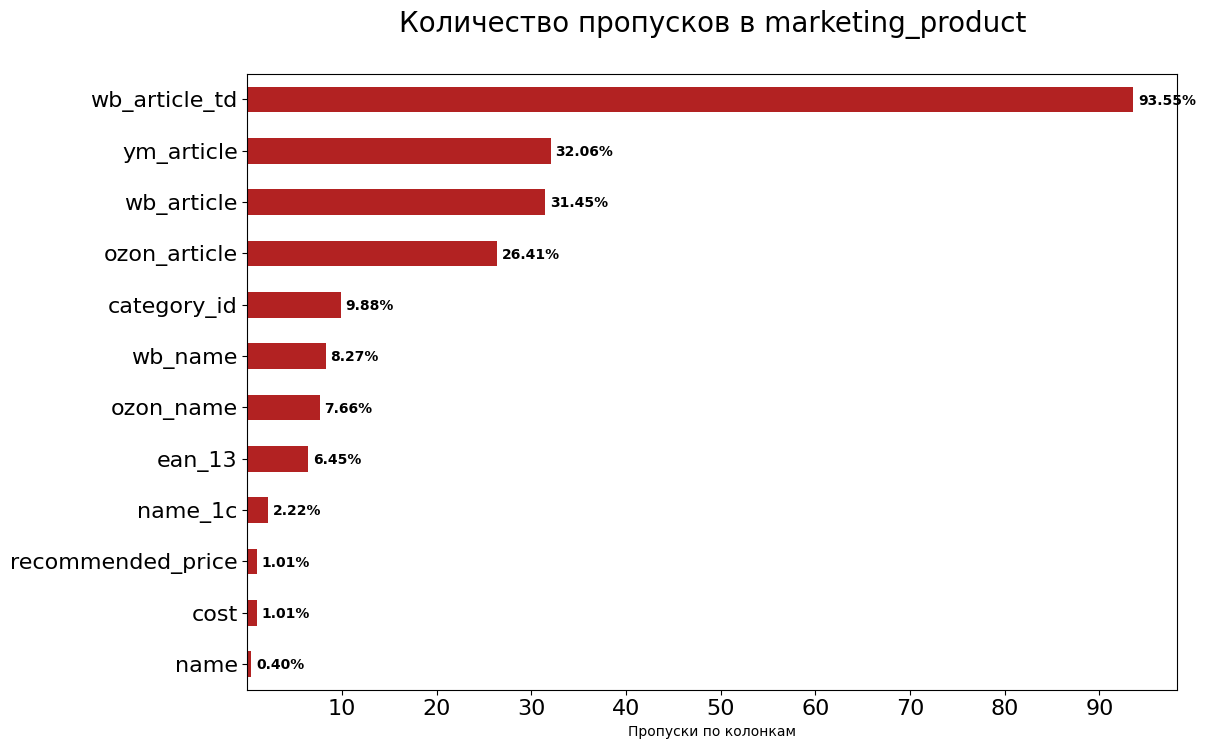

In [40]:
prosept.check_misses_marketing_product()

В данных есть много пропусков.

1. Первая группа пропусков - это `article` маркетплейсов. На первом месте `wb_article_td` - вероятно, это калонка имеет связь с `wb_article`, а `td` = `to discuss`;
2. ~`10%` пропусков;
3. Далее идут имена товаров в `wb` и `ozon`;
4. Затем `European Article Number`;
5. Далее незначительное количество пропусков в цене, рекомендованной цене и названии товара.

Стоит отметить, что в целях анализа нас точно интересуют колонки `name_1c` и `name`. В первой - `2.22%` пропусков, во второй - `name`. Так как строки отражают один и тот же товар, целесообразно, по-возможности, заменить пропуски на значения друг друга.

In [41]:
prosept.check_duplicates_marketing_product()

Дубликаты в "marketing_product" не обнаружены


Посмотрим на дубликаты по колонкам:

In [42]:
prosept.marketing_product[prosept.marketing_product['name'].duplicated()].shape[0]

8

In [43]:
prosept.marketing_product[prosept.marketing_product['name'].duplicated(keep=False)].sort_values(by='name')

,article,ean_13,name,cost,recommended_price,category_id,ozon_name,name_1c,wb_name,ozon_article,wb_article,ym_article,wb_article_td
id,,,,,,,,,,,,,
363,0024-7б,4.680008e+12,"Герметик акриловой цвет Белый, 7 кг",3149.0,5492.0,25.0,Герметик акриловый для швов для деревянных дом...,"Герметик акриловой цвет Белый, 7 кг",Герметик акриловый для швов для деревянных дом...,NaN,NaN,NaN,NaN
502,0024-7 б,NaN,"Герметик акриловой цвет Белый, 7 кг",NaN,NaN,NaN,NaN,NaN,NaN,189522867.0,150126216.0,0024-7-б,NaN
223,0024-3 б,4.610093e+12,"Герметик акриловый цвет Белый, 3 кг",1251.0,2145.0,25.0,Герметик акриловый для швов для деревянных дом...,"Герметик акриловый цвет Белый, 3 кг",Герметик акриловый для швов для деревянных дом...,453200111.0,150126218.0,0024-3-б,NaN
362,0024-3б,NaN,"Герметик акриловый цвет Белый, 3 кг",1251.0,2145.0,25.0,NaN,"Герметик акриловый цвет Белый, 3 кг",NaN,NaN,NaN,NaN,NaN
225,0024-3 м,4.610093e+12,"Герметик акриловый цвет Медовый, 3 кг",1251.0,2145.0,25.0,Герметик акриловый для швов для деревянных дом...,"Герметик акриловый цвет Медовый, 3 кг",Герметик акриловый для швов для деревянных дом...,453214675.0,150126205.0,0024-3-м,NaN
366,0024-3м,NaN,"Герметик акриловый цвет Медовый, 3 кг",1251.0,2145.0,25.0,NaN,"Герметик акриловый цвет Медовый, 3 кг",NaN,NaN,NaN,NaN,NaN
224,0024-3 о,4.610093e+12,"Герметик акриловый цвет Орех, 3 кг",1251.0,2145.0,25.0,Герметик акриловый для швов для деревянных дом...,"Герметик акриловый цвет Орех, 3 кг",Герметик акриловый для швов для деревянных дом...,453205718.0,150126215.0,0024-3-о,NaN
374,0024-3о,NaN,"Герметик акриловый цвет Орех, 3 кг",1251.0,2145.0,25.0,NaN,"Герметик акриловый цвет Орех, 3 кг",NaN,NaN,NaN,NaN,NaN
226,0024-3 с,4.610093e+12,"Герметик акриловый цвет Сосна, 3 кг",1251.0,2145.0,25.0,Герметик акриловый для швов для деревянных дом...,"Герметик акриловый цвет Сосна, 3 кг",Герметик акриловый для швов для деревянных дом...,453215204.0,150126208.0,0024-3-с,NaN


Нужно избавиться от дубликатов. Однако перед этим сохраним индексы. Получим словарь со значением которое осталось и значение, которое удалили:

In [44]:
keep_dict = dict(zip(prosept.marketing_product[prosept.marketing_product['name'].duplicated(keep='last')].index,
                     prosept.marketing_product[prosept.marketing_product['name'].duplicated(keep='first')].index))

Удалим дубликаты и пропуски:

In [45]:
prosept.marketing_product.drop_duplicates(subset=['name'], inplace=True)
prosept.marketing_product.dropna(subset=['name'],inplace=True)

Проверим корректность удаления дубликов:

In [46]:
prosept.marketing_product[prosept.marketing_product['name'].duplicated()].shape[0]

0

### Заполняем name_1c & name

Посмотрим на схожесть этих колонок:

In [47]:
prosept.marketing_product[prosept.marketing_product['name'] == prosept.marketing_product['name_1c']].shape[0]

145

`151` значения идентичные, остальные отличаются. Заменим пропуски в `name_1c` на значения из `name`:

In [48]:
prosept.marketing_product['name_1c'] = np.where(prosept.marketing_product['name_1c'].isna(),
                                                  prosept.marketing_product['name_1c'].fillna(prosept.marketing_product['name']),
                                                  prosept.marketing_product['name_1c'])

Проверим корректности замены пропусков пропусков:

In [49]:
prosept.marketing_product['name_1c'][prosept.marketing_product['name_1c'].isna()].shape[0]

0

Замена произведена корректно

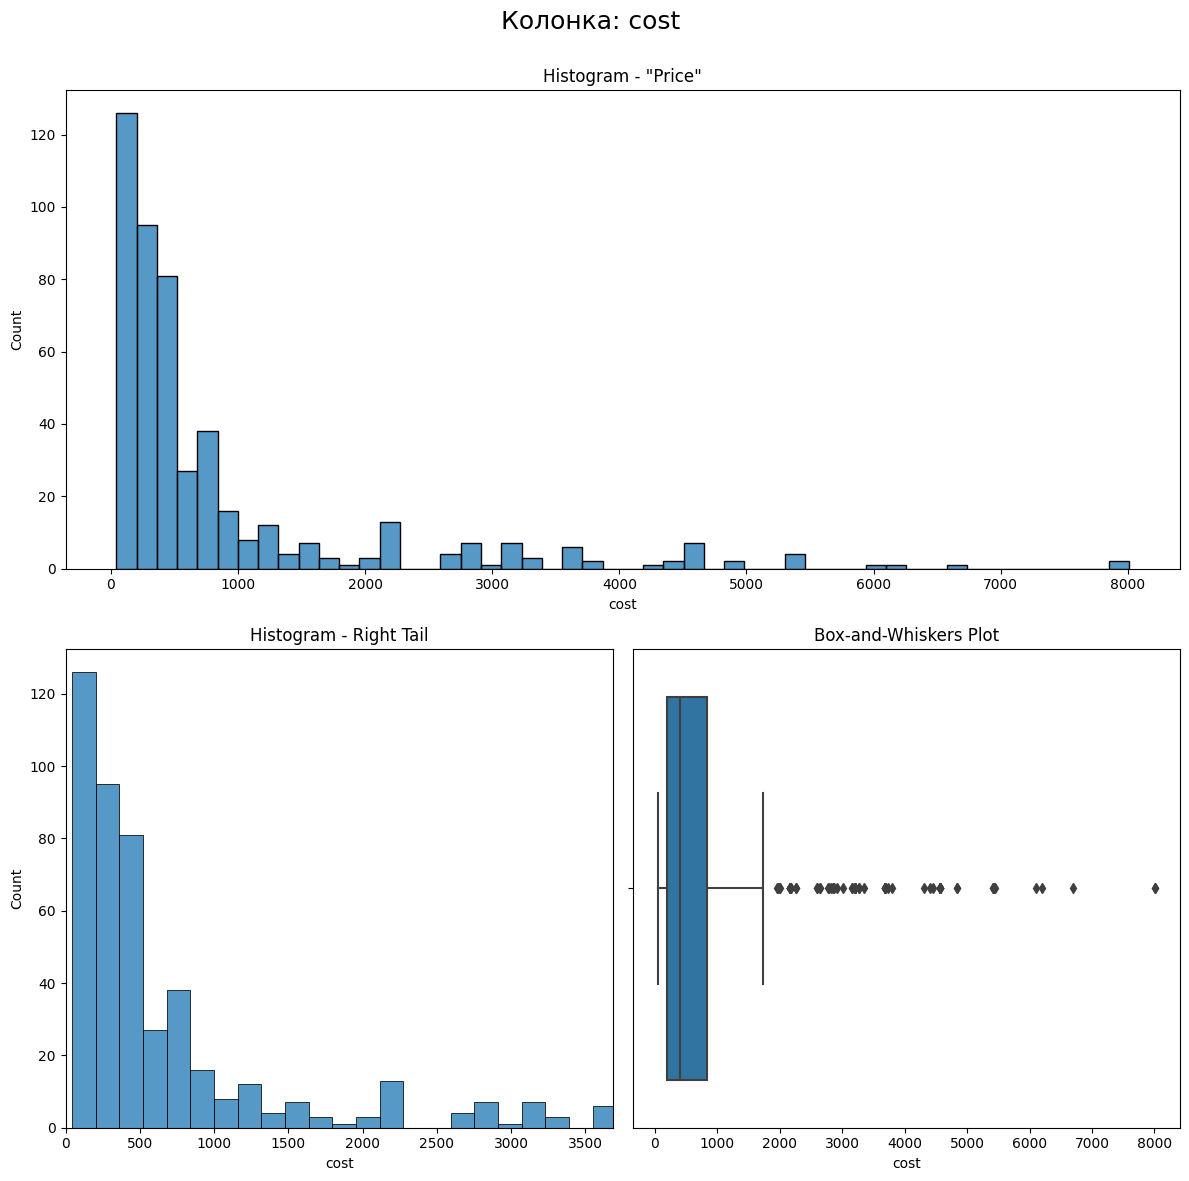

In [50]:
analyzer.plot_hist(prosept.marketing_product['cost'])

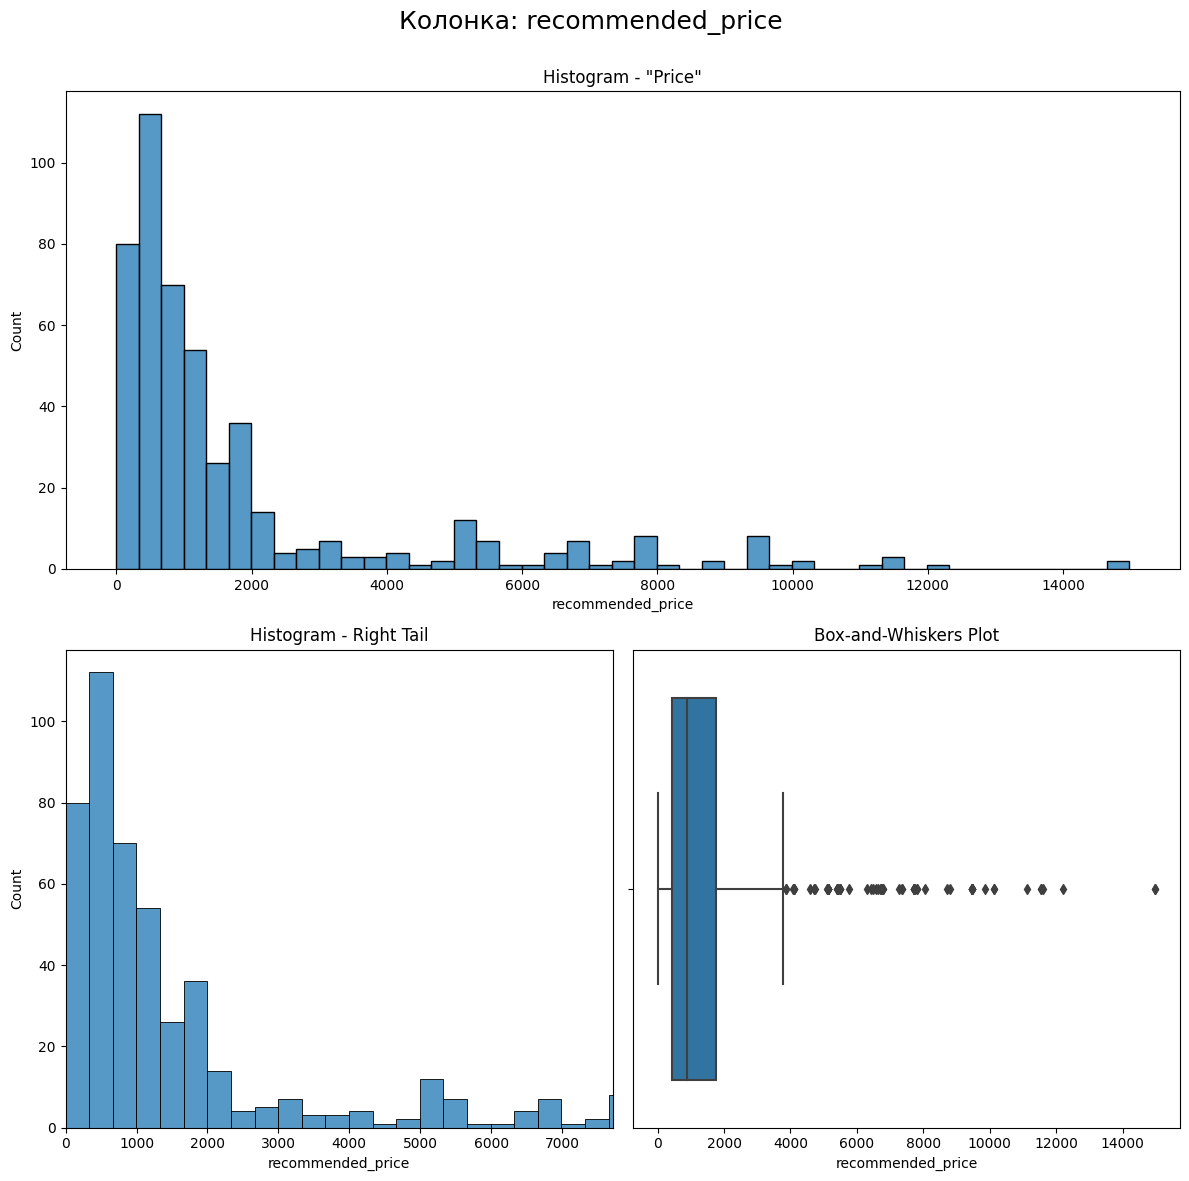

In [51]:
analyzer.plot_hist(prosept.marketing_product['recommended_price'])

Вероятно, столбцы ~ похожи между собой. Логично предположить, что коэффициент наценки должен быть +- одинаковый. Проверим:

In [52]:
round(prosept.marketing_product['recommended_price'].corr(prosept.marketing_product['cost']), 2)

0.99

Коэффициент корреляции - `0.99`. Что говорит о том, что столбец `cost`, скорее всего, не будет представлять для нас никакой полезной информации.

Удалим ненужные колонки:

In [53]:
prosept.marketing_product = prosept.marketing_product[['name','name_1c']]

In [54]:
prosept.marketing_product.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 487 entries, 1 to 513
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   name     487 non-null    object
 1   name_1c  487 non-null    object
dtypes: object(2)
memory usage: 11.4+ KB


### Вывод:

Данные представляют собой данные о позициях клиента. Изначальный датафрейм состоял из `496` строк.

В ходе анализа были обнаружены следующие обстоятельства:
1. В данных есть дубликаты по колонке `article`, которые были вызваны лишними пробелами. В связи с этим возникают различные аномалии и пропуски. Удалили неверные значения;
2. Данные из `name` и `name_1c` похожи на `30%`. При этом в колонке `name_1c` наблюдаются `2.22%` пропусков, заполнили их значениями из `name`

## Marketing_product_dealer_key

In [55]:
prosept.marketing_product_dealer_key.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1700 entries, 1 to 2023
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   key         1700 non-null   object
 1   dealer_id   1700 non-null   int64 
 2   product_id  1700 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 53.1+ KB


In [56]:
prosept.marketing_product_dealer_key.sample(5, random_state=RANDOM_SEED)

,key,dealer_id,product_id
id,,,
1875,528623838,18,258
1094,3707761,13,406
714,98267814,8,245
185,100163759,3,285
1555,15881620,15,43


In [57]:
prosept.marketing_product_dealer_key[prosept.marketing_product_dealer_key['product_id'].isna()].shape[0]

0

Можно удалить пустые значения:

In [58]:
prosept.marketing_product_dealer_key.dropna(subset=['product_id'], inplace=True)

Заменим `float` на `int` в `product_id`

In [59]:
prosept.marketing_product_dealer_key['product_id'] = prosept.marketing_product_dealer_key['product_id'].astype(int)

Проверим, есть ли в датасете референс к нашим удаленным товарам:

In [60]:
prosept.marketing_product_dealer_key.head()

,key,dealer_id,product_id
id,,,
1,546227,2,12
2,651265,2,106
3,546257,2,200
4,546408,2,38
5,651258,2,403


In [61]:
ind_false = prosept.marketing_product_dealer_key[prosept.marketing_product_dealer_key['product_id'].isin(keep_dict.keys())].index
prosept.marketing_product_dealer_key[prosept.marketing_product_dealer_key['product_id'].isin(keep_dict.keys())]

,key,dealer_id,product_id
id,,,
1274,26391137,16,222
1275,26391083,16,227
1409,18381715,15,363
1659,25458273,15,223
1660,25458159,15,225
1661,25458153,15,224
1839,858663048,17,226
1840,860500818,17,224
1841,860592578,17,225


Такие значения имеются. Заменим их на актуальные:

In [62]:
prosept.marketing_product_dealer_key.replace(keep_dict, inplace=True)

Посмотрим на результат замены:

In [63]:
prosept.marketing_product_dealer_key[prosept.marketing_product_dealer_key.index.isin(ind_false)].head(5)

,key,dealer_id,product_id
id,,,
1274,26391137,16,362
1275,26391083,16,463
1409,18381715,15,502
1659,25458273,15,366
1660,25458159,15,374


Замена выполнена конкретно

In [64]:
prosept.check_misses_marketing_product_dealer_key()

Пропуски в датасете "marketing_product_dealer_key" не обнаружены


In [65]:
prosept.check_duplicates_marketing_product_dealer_key()

Дубликаты в "marketing_product_dealer_key" не обнаружены


### Вывод

Некоторые ключи ввели к неверным `article` из датасета `marketing_product`. Мы сохранили словарь, который позволил произведи замену неверных ключей на верные.

# Merge DF

Соединим всю информацию воедино:

In [66]:
prosept.merger()

Посмотрим первичную информацию:

In [67]:
prosept.merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1613 entries, 0 to 1612
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             1613 non-null   int64 
 1   product_name   1613 non-null   object
 2   product_id     1613 non-null   int64 
 3   original_name  1613 non-null   object
 4   name_1c        1613 non-null   object
dtypes: int64(2), object(3)
memory usage: 75.6+ KB


In [68]:
prosept.merged_df.head(5)

,id,product_name,product_id,original_name,name_1c
0,919,Средство для удаления цемента Prosept Cement C...,400,Удалитель цемента CEMENT CLEANER готовый соста...,"Удалитель цемента PROSEPT CEMENT CLEANER, 0.5 л."
1,2461,"СредстводляудаленияцементаProseptСementСlean0,5л",400,Удалитель цемента CEMENT CLEANER готовый соста...,"Удалитель цемента PROSEPT CEMENT CLEANER, 0.5 л."
2,19314,Средство для удаления цемента Prosept Сement С...,400,Удалитель цемента CEMENT CLEANER готовый соста...,"Удалитель цемента PROSEPT CEMENT CLEANER, 0.5 л."
3,20237,CEMENT CLEANER удалитель цемента,400,Удалитель цемента CEMENT CLEANER готовый соста...,"Удалитель цемента PROSEPT CEMENT CLEANER, 0.5 л."
4,19148,Просепт Professional Cement Cleaner удалитель ...,400,Удалитель цемента CEMENT CLEANER готовый соста...,"Удалитель цемента PROSEPT CEMENT CLEANER, 0.5 л."


Как видно из датафрейма, `original_name` соответствуют различным `product_name` с различных площадок. Нужно будет учитывать этот момент при построении модели.

### Обработка данных

Создадим функцию для отчистки текста:

In [69]:
extra_words = (
    # Список слов для удаления из описания
    r'(?:готовый\sсостав|для|концентрат|просепт|prosept|средство|невымываемая|гелеобразный|канистра|всх|типов|бесконтактного|поверхностей|любых|спрей|удаления|других|'
    r'чистящее|чистящий|пэт|жидкое|моющее|гель|чистки|мытья|готовый|раствор|ответственных|конструкций|eco|'
    r'концентрированное|professional|готовое|superrubber|биопоражении)'
)
 
def clean_description(text):
 
    # Приведение текста к нижнему регистру
    text = text.lower()
 
    # Удаление чисел в скобках
    text = re.sub(r'\(\d+\)', ' ', text)
 
    # Вставка пробелов между кириллицей и латиницей
    text = re.sub(r'(?<=[а-яА-Я])(?=[a-zA-Z])|(?<=[a-zA-Z])(?=[а-яА-Я])', ' ', text)
 
    # Добавление пробелов между цифрами и буквами
    text = re.sub(r'(?<=\d)(?=[а-яА-Яa-zA-Z])', ' ', text)
    text = re.sub(r'(?<=[а-яА-Яa-zA-Z])(?=\d)', ' ', text)
 
    # Удаление диапазонов чисел, разделенных дефисом или двоеточием
    text = re.sub(r'\b\d+(?::\d+)?[-:]\d+(?::\d+)?\b', ' ', text)
 
    # Удаление серийных номеров или артикулов
    text = re.sub(r'\b\d+-\d+[а-яА-Яa-zA-Z]*\b', ' ', text)
 
    # Добавление пробелов между цифрами и "л"
    re.sub(r'(\d)(л)', r'\1 \2', text)
 
    # Преобразование объемов из литров в миллилитры и веса из кг в граммы
    text = re.sub(r'(\d+[,.]\d+)\s*л', lambda x: f"{int(float(x.group(1).replace(',', '.')) * 1000)} мл", text)
    text = re.sub(r'(\d+[,.]\d+)\s*кг', lambda x: f"{int(float(x.group(1).replace(',', '.')) * 1000)} г", text)
 
    # Замена "/" и "." между слов на пробелы
    text = re.sub(r'[/\.]', ' ', text)
 
    text = text.replace('-', ' ')
 
    # Удаление избыточных слов из списка extra_words
    text = re.sub(extra_words, ' ', text)
 
    # Удаление пунктуационных знаков и специальных символов
    text = re.sub(r'[,"“”/\.()–;]', ' ', text)
 
    # Удаление слова "и"
    text = re.sub(r'\bи\b', ' ', text)
 
    # Удаление дефисов, окруженных пробелами
    text = re.sub(r'\s-\s', ' ', text)
 
    # Удаление всех двойных пробелов и пробелов в начале/конце строки
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
 
    return text


In [70]:
prosept.merged_df['product_name_normalized'] = prosept.merged_df['product_name'].apply(clean_description)
prosept.merged_df['original_name_normalized'] = prosept.merged_df['original_name'].apply(clean_description)
prosept.merged_df['1c_name_normalized'] = prosept.merged_df['name_1c'].apply(clean_description)

### Создаем модель ранжирования и сопоставления товаров.

Инициализируем модель:

In [71]:
model = SentenceTransformer('LaBSE')

Рассчитаем эмбединги:

In [72]:
prosept.merged_df['original_name_embeddings'] = model.encode(prosept.merged_df['original_name_normalized'].values).tolist()
prosept.merged_df['product_name_embeddings'] = model.encode(prosept.merged_df['product_name_normalized'].values).tolist()
prosept.merged_df['1c_name_embeddings'] = model.encode(prosept.merged_df['1c_name_normalized'].values).tolist()

Определим метрику расчёта. Была выбрана метрика `recall_at_k`, поскольку нам важно получить истинное значение в `n` вариантах

In [73]:
# Функция для расчета Recall at K
def recall_at_k(predicted, correct, k=5):
    return int(correct in predicted[:k])

In [74]:
unique_original_embeddings = prosept.merged_df.drop_duplicates(subset=['product_id'])[['product_id', 'original_name_embeddings']]
unique_embeddings_matrix = torch.tensor(np.stack(unique_original_embeddings['original_name_embeddings'].values), dtype = torch.float32)
product_name_embeddings = torch.tensor(prosept.merged_df['product_name_embeddings'], dtype = torch.float32)
similarity = util.cos_sim(product_name_embeddings, unique_embeddings_matrix)
# Ранжирование товаров и подсчет Recall at 5
total_recall = 0
max_positions = np.argsort(similarity, axis=1)[:, -5:]#Топ-5 сходных элементов
max_positions_reverse = torch.flip(max_positions, [1])

for index, row in prosept.merged_df.iterrows():
    
    
    top_5_indices = max_positions_reverse[index]  # Топ-5 индексов с наименьшими расстояниями

    # Получаем ID топ-5 товаров
    top_5_products_ids = unique_original_embeddings.iloc[top_5_indices]['product_id'].values

    # Добавляем recall для текущего товара
    total_recall += recall_at_k(top_5_products_ids, row['product_id'])

average_recall = total_recall / len(prosept.merged_df)
print(f"Средний Recall на Топ-5: {average_recall}")

Поиск соответствия в столбце 'name'. Средний Recall на Топ-5: 0.99


In [75]:
unique_original_embeddings_2 = prosept.merged_df.drop_duplicates(subset=['product_id'])[['product_id', '1c_name_embeddings']]
unique_embeddings_matrix_2 = torch.tensor(np.stack(unique_original_embeddings_2['1c_name_embeddings'].values), dtype = torch.float32)
product_name_embeddings = torch.tensor(prosept.merged_df['product_name_embeddings'], dtype = torch.float32)
similarity = util.cos_sim(product_name_embeddings, unique_embeddings_matrix_2)

# Ранжирование товаров и подсчет Recall at 5
total_recall = 0
max_positions = np.argsort(similarity, axis=1)[:, -5:]#Топ-5 сходных элементов
max_positions_reverse = torch.flip(max_positions, [1])
for index, row in prosept.merged_df.iterrows():
    # Расчет расстояний

    top_5_indices = max_positions_reverse[index]  # Топ-5 индексов с наименьшими расстояниями

    # Получаем ID топ-5 товаров
    top_5_products_ids = unique_original_embeddings_2.iloc[top_5_indices]['product_id'].values

    score = recall_at_k(top_5_products_ids, row['product_id'])

    # Добавляем recall для текущего товара
    total_recall += score

average_recall = total_recall / len(prosept.merged_df)
print(f"Поиск соответствия в столбце 'name_1c'. Средний Recall на Топ-5: {round(average_recall, 2)}")

Поиск соответствия в столбце 'name_1c'. Средний Recall на Топ-5: 0.98


Таким образом, удалось достигнуть метрики `Recall `:

* `0.99` - при поиске соответствия в столбце `name`
* `0.98` - при поиске соответствия в столбце `name_1c`

### Сохраняем модель:

In [76]:
#model.save('model')

## Демонстрация работы модели на случайном примере.

In [77]:
# Генерация случайного индекса
random_index = random.randint(0, len(prosept.merged_df) - 1)
random_product = prosept.merged_df.iloc[random_index]
random_product = torch.tensor(random_product['product_name_embeddings'], dtype = torch.float32)
print(f"Выбранный товар: {random_product['product_name']} (ID: {random_product['product_id']})")

# Расчет расстояний для выбранного товара
similarity = util.cos_sim(random_product, unique_embeddings_matrix)
# Ранжирование товаров и подсчет Recall at 5
total_recall = 0
max_positions = np.argsort(similarity, axis=1)[:, -5:]#Топ-5 сходных элементов
max_positions_reverse = torch.flip(max_positions, [1])


top_5_indices = max_positions_reverse  # Топ-5 индексов с наименьшими расстояниями

# Получение рекомендаций
top_5_recommendations = unique_original_embeddings.iloc[top_5_indices]
print("\nТоп-5 рекомендованных товаров:")
for idx, row in top_5_recommendations.iterrows():
    print(f"ID: {row['product_id']}, Название: {prosept.merged_df[prosept.merged_df['product_id'] == row['product_id']]['original_name'].iloc[0]}")

Выбранный товар: Отбеливатель для древесины Prosept ЕСО 50 5л (ID: 269)

Топ-5 рекомендованных товаров:
ID: 269, Название: Отбеливатель для древесиныPROSEPT ECO 50готовый состав / 5 л
ID: 241, Название: Отбеливатель для древесины PROSEPT 50концентрат 1:1 / 5 л
ID: 270, Название: Отбеливатель для древесиныPROSEPT ECO 50готовый состав / 10 л
ID: 244, Название: Отбеливатель для древесиныPROSEPT 50концентрат 1:1 / 30 л
ID: 242, Название: Отбеливатель для древесиныPROSEPT 50концентрат 1:1 / 10 л


## Краткий отчет о выполнении проекта

В ходе проекта были выполнены следующие этапы:

- Проведено исследование таблиц и их объединение по ключам.
- Разработана функция для унификации наименований товаров на сайте Заказчика и на сайтах дилеров с использованием регулярных выражений.
- Разработан baseline модели, который предусматривал:
  -  создание эмбеддингов при помощи модели bert-base-multilingual-cased;
  -  расчет косинусного расстояния между эмбеддингом наименования каждого продукта с сайта дилера и всеми уникальными наименованиями продуктов с сайта заказчика при помощи метода pdist() библиотеки scipy и ранжирование эмбеддингов в зависимости от рассчитанного расстояния;
  -  предложение 5 вариантов продуктов с сайта заказчика с наименьшим косинусным расстоянием до целевого продукта с сайта дилера.
- Оптимизация baseline путем подбора оптимальной модели для создания эмбеддингов (в итоге остановились на Sentence Transformer LaBSE (Language-agnostic BERT Sentence Embedding)) и доработки функции унификации наименований. Удалось довести метрику recall at 5 до 0.98.
- Упаковка решения в скрипт для backend-разработчиков.